<h2> 6. Bayes Classification </h2>

This notebook has the code for the charts in Chapter 6


<h3> Exploration using BigQuery </h3>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datalab.bigquery as bq

In [2]:
sql = """
SELECT DISTANCE, DEP_DELAY
FROM `flights.tzcorr`
WHERE RAND() < 0.001 AND dep_delay > -20 AND dep_delay < 30 AND distance < 2000
"""
df = bq.Query(sql).to_dataframe(dialect='standard')

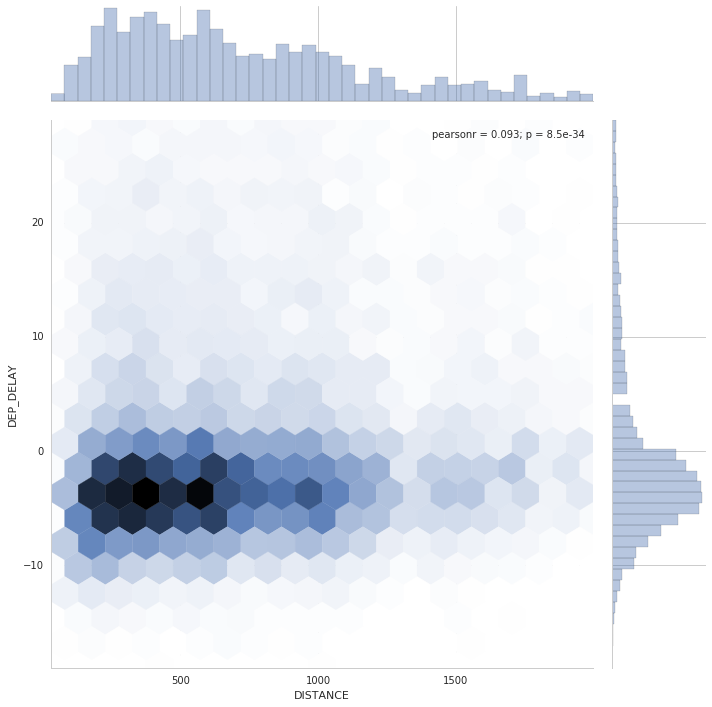

In [3]:
sns.set_style("whitegrid")
g = sns.jointplot(df['DISTANCE'], df['DEP_DELAY'], kind="hex", size=10, joint_kws={'gridsize':20})

<h3> Set up views in Spark SQL </h3>

Note that a SparkSession object already exists in Datalab:

In [4]:
print spark

In a standalone script, we'd have to do:
<pre>
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("Bayes classification using Spark") \
    .getOrCreate()
</pre>

Set up the schema to read in the CSV files on GCS

In [5]:
from pyspark.sql.types import StringType, FloatType, StructType, StructField

header = 'FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,DISTANCE,DEP_AIRPORT_LAT,DEP_AIRPORT_LON,DEP_AIRPORT_TZOFFSET,ARR_AIRPORT_LAT,ARR_AIRPORT_LON,ARR_AIRPORT_TZOFFSET,EVENT,NOTIFY_TIME'

def get_structfield(colname):
   if colname in ['ARR_DELAY', 'DEP_DELAY', 'DISTANCE']:
      return StructField(colname, FloatType(), True)
   else:
      return StructField(colname, StringType(), True)

schema = StructType([get_structfield(colname) for colname in header.split(',')])
print schema

StructType(List(StructField(FL_DATE,StringType,true),StructField(UNIQUE_CARRIER,StringType,true),StructField(AIRLINE_ID,StringType,true),StructField(CARRIER,StringType,true),StructField(FL_NUM,StringType,true),StructField(ORIGIN_AIRPORT_ID,StringType,true),StructField(ORIGIN_AIRPORT_SEQ_ID,StringType,true),StructField(ORIGIN_CITY_MARKET_ID,StringType,true),StructField(ORIGIN,StringType,true),StructField(DEST_AIRPORT_ID,StringType,true),StructField(DEST_AIRPORT_SEQ_ID,StringType,true),StructField(DEST_CITY_MARKET_ID,StringType,true),StructField(DEST,StringType,true),StructField(CRS_DEP_TIME,StringType,true),StructField(DEP_TIME,StringType,true),StructField(DEP_DELAY,FloatType,true),StructField(TAXI_OUT,StringType,true),StructField(WHEELS_OFF,StringType,true),StructField(WHEELS_ON,StringType,true),StructField(TAXI_IN,StringType,true),StructField(CRS_ARR_TIME,StringType,true),StructField(ARR_TIME,StringType,true),StructField(ARR_DELAY,FloatType,true),StructField(CANCELLED,StringType,true)

Create a table definition (this is done lazily; the files won't be read until we issue a query):

In [6]:
#inputs = 'gs://cloud-training-demos-ml/flights/tzcorr/all_flights-00000-*' # 1/30th
inputs = 'gs://cloud-training-demos-ml/flights/tzcorr/all_flights-*'  # FULL
flights = spark.read\
            .schema(schema)\
            .csv(inputs)

# this view can now be queried ...
flights.createOrReplaceTempView('flights')

Example query over the view:

In [7]:
results = spark.sql('SELECT COUNT(*) FROM flights WHERE dep_delay > -20 AND distance < 2000')
results.show()

+--------+
|count(1)|
+--------+
| 6582994|
+--------+



<h2> Restrict to train days </h2>

Create dataframe of traindays, but this time because the file has a header, and is a small file, we can have Spark infer the schema

In [8]:
traindays = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv('gs://cloud-training-demos-ml/flights/trainday.csv')

traindays.createOrReplaceTempView('traindays')

In [9]:
results = spark.sql('SELECT * FROM traindays')
results.head(5)

[Row(FL_DATE=datetime.datetime(2015, 1, 1, 0, 0), is_train_day=True),
 Row(FL_DATE=datetime.datetime(2015, 1, 2, 0, 0), is_train_day=False),
 Row(FL_DATE=datetime.datetime(2015, 1, 3, 0, 0), is_train_day=False),
 Row(FL_DATE=datetime.datetime(2015, 1, 4, 0, 0), is_train_day=True),
 Row(FL_DATE=datetime.datetime(2015, 1, 5, 0, 0), is_train_day=True)]

In [10]:
statement = """
SELECT
  f.FL_DATE AS date,
  distance,
  dep_delay
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day AND
  f.dep_delay IS NOT NULL
ORDER BY
  f.dep_delay DESC
"""
flights = spark.sql(statement)

<h3> Hexbin plot </h3>

Create a hexbin plot using Spark (repeat of what we did in BigQuery, except that we are now restricting to train days only).

In [11]:
df = flights[(flights['distance'] < 2000) & (flights['dep_delay'] > -20) & (flights['dep_delay'] < 30)]
df.describe().show()

+-------+-----------------+-------------------+
|summary|         distance|          dep_delay|
+-------+-----------------+-------------------+
|  count|          4228154|            4228154|
|   mean|711.9580493047321|-0.2872215628853632|
| stddev|442.3360453916574|  8.205215958812529|
|    min|             30.0|              -19.0|
|    max|           1999.0|               29.0|
+-------+-----------------+-------------------+



Sample the dataframe so that it fits into memory (not a problem in development, but will be on full dataset); then plot it.

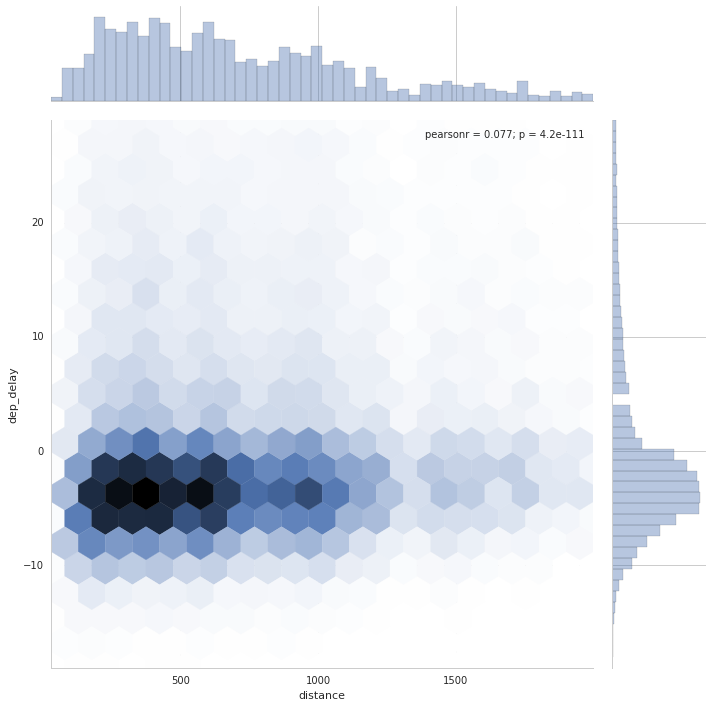

In [12]:
pdf = df.sample(False, 0.02, 20).toPandas()  # to 100,000 rows approx on complete dataset
g = sns.jointplot(pdf['distance'], pdf['dep_delay'], kind="hex", size=10, joint_kws={'gridsize':20})

<h3> Quantization </h3>

Now find the quantiles

In [13]:
distthresh = flights.approxQuantile('distance', list(np.arange(0, 1.0, 0.1)), 0.02)
distthresh

[30.0, 251.0, 368.0, 448.0, 575.0, 669.0, 838.0, 1012.0, 1218.0, 1849.0]

In [14]:
delaythresh = flights.approxQuantile('dep_delay', list(np.arange(0, 1.0, 0.1)), 0.05)
delaythresh

[-82.0, -6.0, -5.0, -4.0, -3.0, 0.0, 3.0, 5.0, 11.0, 39.0]

In [15]:
results = spark.sql('SELECT COUNT(*) FROM flights WHERE dep_delay >= 3 AND dep_delay < 8 AND distance >= 447 AND distance < 557')
results.show()

+--------+
|count(1)|
+--------+
|   41738|
+--------+



<h2> Repeat, but on full dataset </h2>

Here, I'm going to launch on the full dataset from within Datalab because I want the statistics and graphs updated. If I didn't, 
I would have created a standalone Python script and submitted it to the cluster -- there is no need to put Datalab in the middle of a production process. We'll submit a standalone Pig program to the cluster in the next section.

Steps:
<ol>
<li> Change the input variable to process all-flights-* </li>
<li> Increase cluster size (bash increase_cluster.sh) </li>
<li> Clear all cells from this notebook </li>
<li> Run all cells </li>
<li> Decrease cluster size (bash decrease_cluster.sh) </li>
</ol>
